**STEP 0 - Fix malformed CSV lines-**
*If raw file throws a pandas parse error like “EOF inside string”, run this first. It stitches broken lines where quotes weren’t closed, then writes a fixed CSV.*

In [20]:
# --- 0) CSV fixer: balances unclosed quotes by stitching lines ---
import io

SRC = "/content/order_data.csv"          # upload your raw file here
DST = "/content/order_data_fixed.csv"    # <- use this path in later cells

def fix_csv_quotes(src_path, dst_path, encoding="utf-8"):
    fixed = 0; written = 0
    with io.open(src_path, "r", encoding=encoding, errors="replace") as fin, \
         io.open(dst_path, "w", encoding="utf-8", newline="") as fout:
        header = fin.readline()
        if not header: raise SystemExit("Empty file.")
        fout.write(header.rstrip("\n") + "\n")
        buf = ""
        for line in fin:
            line = line.rstrip("\n")
            buf = line if not buf else buf + "\n" + line
            if buf.count('"') % 2 == 0:           # even quotes → safe to flush
                fout.write(buf + "\n"); written += 1; buf = ""
            else:
                fixed += 1                        # keep buffering until even
        if buf and buf.count('"') % 2 == 0:
            fout.write(buf + "\n"); written += 1
    print(f"✅ Fixed CSV → {dst_path} | ~joined lines: {fixed} | rows written: {written}")

# Run only if you get parsing errors:
# fix_csv_quotes(SRC, DST)


**STEP 1 - Light, model-compatible cleaning + inline data preview-**
*Reads the (fixed) CSV, parses the ORDERS column into lists without changing item tokens/case, computes CART_SIZE, drops truly empty carts for EDA, and shows a preview of the cleaned frame right in Colab.*

In [21]:
# --- 1) Clean & preview (non-destructive for model compatibility) ---
import pandas as pd, numpy as np, re, json, os

# If you ran the fixer, use the fixed file; otherwise switch to /content/order_data.csv
ORDERS_PATH = "/content/order_data_fixed.csv"
OUT_DIR = "/content/eda_only"
os.makedirs(OUT_DIR, exist_ok=True)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

def normalize_whitespace(s: str) -> str:
    return re.sub(r"\s+", " ", str(s)).strip()

def parse_orders_cell(s):
    """Parse ORDERS cell as JSON or delimited text — do NOT lowercase/rename items."""
    if pd.isna(s): return []
    t = str(s).strip().strip('"').strip("'")
    if not t: return []
    if t.startswith("[") and t.endswith("]"):
        try:
            arr = json.loads(t)
            return [normalize_whitespace(x) for x in arr if str(x).strip()]
        except Exception:
            pass
    for sep in ["||","|",";","\t",","]:
        if sep in t:
            return [normalize_whitespace(x) for x in t.split(sep) if x.strip()]
    return [normalize_whitespace(x) for x in re.split(r"[|;,]\s*|\s{2,}", t) if x]

print("🔹 Loading orders…")
df = pd.read_csv(ORDERS_PATH, on_bad_lines="skip", encoding="utf-8")

# Ensure expected columns exist (don’t break your model schema)
for col in ["CUSTOMER_ID","ORDER_ID","ORDER_CHANNEL_NAME","ORDER_SUBCHANNEL_NAME",
            "ORDER_OCCASION_NAME","STORE_NUMBER","CUSTOMER_TYPE","ORDERS"]:
    if col not in df.columns:
        df[col] = ""

# Parse orders for EDA visibility (your model can still read the raw file separately)
df["ORDERS_LIST"] = df["ORDERS"].apply(parse_orders_cell)
df["CART_SIZE"] = df["ORDERS_LIST"].map(len)

# EDA frame: drop empty carts only for analysis visuals
eda_df = df[df["CART_SIZE"] > 0].copy()
print(f"✅ Cleaned for EDA → rows: {len(eda_df):,} of {len(df):,}")

# Inline preview
display(eda_df.head(10))
display(eda_df.tail(10))


🔹 Loading orders…
✅ Cleaned for EDA → rows: 1,414,410 of 1,414,410


,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDERS,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,ORDERS_LIST,CART_SIZE
0,362204699,2156,2024-07-24,7247194287,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",12
1,269612955,1419,2025-02-15,791214421,"{""orders"": [{""item_details"": [{""item_name"": ""R...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",12
2,585330633,2249,2025-02-15,7575285208,"{""orders"": [{""item_details"": [{""item_name"": ""2...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",6
3,950661333,2513,2024-03-29,4253875716,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",21
4,434985772,1754,2024-04-08,7150407872,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",21
5,126084616,949,2025-02-15,3060989630,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",6
6,426992703,2156,2025-02-15,1655782790,"{""orders"": [{""item_details"": [{""item_name"": ""1...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",9
7,772568272,820,2025-02-15,4015163280,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,Delivery,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",6
8,715522716,1161,2024-06-08,3057756219,"{""orders"": [{""item_details"": [{""item_name"": ""F...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",15
9,591908874,820,2025-02-15,4349588916,"{""orders"": [{""item_details"": [{""item_name"": ""R...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",12


,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDERS,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,ORDERS_LIST,CART_SIZE
1414400,125634365,4595,2025-02-05,4320367143,"{""orders"": [{""item_details"": [{""item_name"": ""A...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",9
1414401,125634365,4595,2024-11-19,6183487128,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",9
1414402,125634365,1419,2024-09-29,2339533648,"{""orders"": [{""item_details"": [{""item_name"": ""R...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",9
1414403,125634365,1419,2024-11-21,6245115237,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",6
1414404,125634365,1419,2024-12-15,6651171564,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",6
1414405,125634365,4595,2025-02-02,762304305,"{""orders"": [{""item_details"": [{""item_name"": ""1...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",6
1414406,125634365,1419,2025-01-22,9371418183,"{""orders"": [{""item_details"": [{""item_name"": ""C...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",12
1414407,125634365,4595,2025-02-13,8082200700,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",6
1414408,125634365,1419,2024-11-30,8865782702,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",6
1414409,125634365,4595,2024-12-16,8030111101,"{""orders"": [{""item_details"": [{""item_name"": ""R...",Digital,WWT,ToGo,,"[{""orders"": [{""item_details"": [{""item_name"": ""...",9


**STEP 2 - Polished EDA setup (themes & safe date detection) -**
*Sets a clean visual style and tries to parse a usable date column (if present) for time-based charts.*

In [22]:
# --- 2) Styling and date prep ---
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.titlesize": 14, "axes.labelsize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10
})

# Detect/parse a date column (best-effort)
date_cols_guess = [c for c in eda_df.columns if any(k in c.upper() for k in ["DATE","CREATED","TIME","TIMESTAMP"])]
parsed_date_col = None
for c in date_cols_guess:
    try:
        eda_df[c] = pd.to_datetime(eda_df[c], errors="coerce")
        if str(eda_df[c].dtype).startswith("datetime"):
            parsed_date_col = c
            break
    except Exception:
        pass

if parsed_date_col:
    eda_df["DAY_OF_WEEK"] = eda_df[parsed_date_col].dt.day_name()
    eda_df["HOUR"] = eda_df[parsed_date_col].dt.hour


**Orders over time & 80/20 Pareto -**
*Show growth/seasonality and how much revenue comes from top items.*

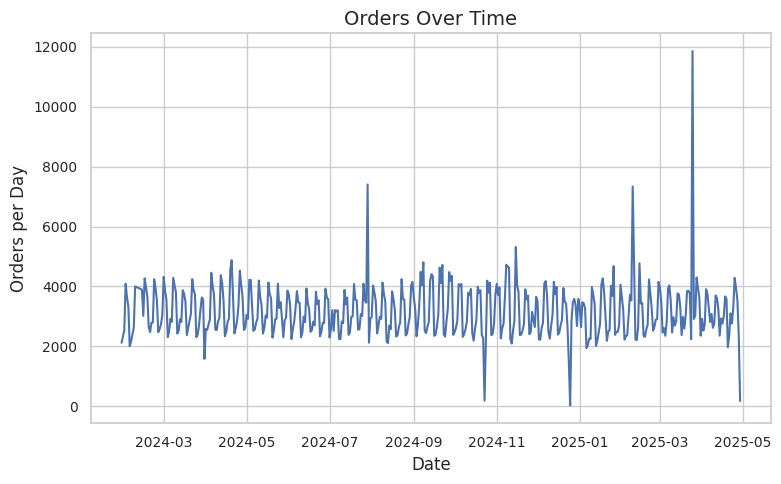

In [24]:
# --- 9) Orders over time + Pareto curve (if date/values exist) ---
import numpy as np

if parsed_date_col:
    daily = eda_df.groupby(eda_df[parsed_date_col].dt.date)["ORDER_ID"].count()
    if not daily.empty:
        ax = daily.plot()
        ax.set_title("Orders Over Time"); ax.set_ylabel("Orders per Day"); ax.set_xlabel("Date")
        plt.tight_layout(); plt.show()

if aov_col:
    item_sales = {}
    for items, total in zip(eda_df["ORDERS_LIST"], eda_df[aov_col].fillna(0)):
        for item in set(items):
            item_sales[item] = item_sales.get(item, 0) + float(total)
    if item_sales:
        sorted_sales = sorted(item_sales.values(), reverse=True)
        cum_share = np.cumsum(sorted_sales) / (sum(sorted_sales) + 1e-12)
        fig, ax = plt.subplots()
        ax.plot(range(1, len(sorted_sales)+1), cum_share)
        ax.axhline(0.8, linestyle="--", color="red")
        ax.set_title("Cumulative Sales Curve (Pareto 80/20)")
        ax.set_xlabel("Top N Items"); ax.set_ylabel("Revenue Share")
        plt.tight_layout(); plt.show()


In [12]:
import pandas as pd, numpy as np, re, json, os
from collections import Counter
import matplotlib.pyplot as plt

# IMPORTANT: point to the fixed file if you ran the fixer above
ORDERS_PATH = "/content/order_data_fixed.csv"  # or "/content/order_data.csv" if you skipped fixing
OUT_DIR = "/content/eda_only"
os.makedirs(OUT_DIR, exist_ok=True)

def normalize_whitespace(s):
    # DO NOT change case or tokens (keeps model’s item strings intact)
    s = str(s)
    return re.sub(r"\s+", " ", s).strip()

def parse_orders_cell(s):
    # Non-destructive: only trims whitespace, doesn’t lowercase or rename
    if pd.isna(s): return []
    t = str(s).strip().strip('"').strip("'")
    if not t: return []
    if t.startswith("[") and t.endswith("]"):
        try:
            arr = json.loads(t)
            return [normalize_whitespace(x) for x in arr if str(x).strip()]
        except Exception:
            pass
    for sep in ["||","|",";","\t",","]:
        if sep in t:
            return [normalize_whitespace(x) for x in t.split(sep) if x.strip()]
    # fallback: split on punctuation or multi-spaces
    return [normalize_whitespace(x) for x in re.split(r"[|;,]\s*|\s{2,}", t) if x]

print("Loading…")
df = pd.read_csv(ORDERS_PATH, on_bad_lines="skip", encoding="utf-8")

# Ensure key columns exist (don’t create new names your model doesn’t expect)
for col in ["CUSTOMER_ID","ORDER_ID","ORDER_CHANNEL_NAME","ORDER_SUBCHANNEL_NAME",
            "ORDER_OCCASION_NAME","STORE_NUMBER","CUSTOMER_TYPE","ORDERS"]:
    if col not in df.columns:
        df[col] = ""

# Parse items only for EDA visibility (your model can still read raw file separately)
df["ORDERS_LIST"] = df["ORDERS"].apply(parse_orders_cell)
df["CART_SIZE"] = df["ORDERS_LIST"].map(len)

# Drop totally empty carts for EDA summaries (does not affect your model notebook)
eda_df = df[df["CART_SIZE"] > 0].copy()
print(f"Rows for EDA: {len(eda_df):,}  (from {len(df):,})")

# Save a clean-ish version for documentation/EDA (not required by your model)
eda_df.to_csv(os.path.join(OUT_DIR, "final_merged_data.csv"), index=False)
print("Saved EDA file →", os.path.join(OUT_DIR, "final_merged_data.csv"))


Loading…
Rows for EDA: 1,414,410  (from 1,414,410)
Saved EDA file → /content/eda_only/final_merged_data.csv


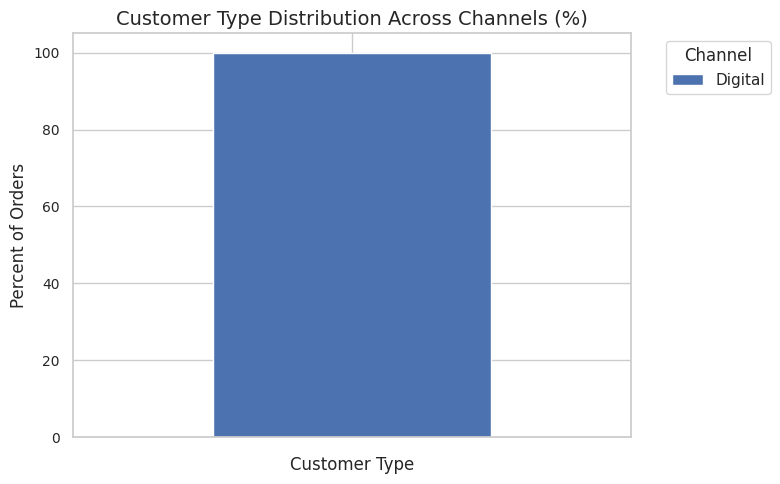

In [25]:
# --- 10) Customer Type × Channel (% share) ---
if "CUSTOMER_TYPE" in eda_df.columns and "ORDER_CHANNEL_NAME" in eda_df.columns:
    xtab = pd.crosstab(eda_df["CUSTOMER_TYPE"], eda_df["ORDER_CHANNEL_NAME"], normalize="index") * 100
    if not xtab.empty:
        ax = xtab.plot(kind="bar", stacked=True)
        ax.set_title("Customer Type Distribution Across Channels (%)")
        ax.set_ylabel("Percent of Orders"); ax.set_xlabel("Customer Type")
        plt.legend(title="Channel", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout(); plt.show()
    else:
        print("No rows to build customer×channel crosstab.")
else:
    print("Missing CUSTOMER_TYPE/ORDER_CHANNEL_NAME — skipping.")


**Top Co-Purchased Pairs (bar chart)**

/tmp/ipython-input-3286740755.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=pair_labels, palette="Blues_r")


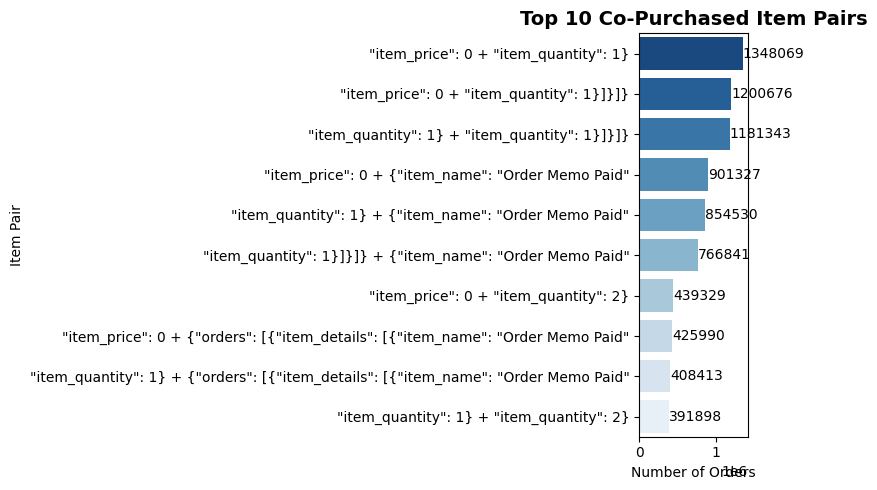

In [17]:
# 📌 Polished Top Pairs Bar Chart
top_pairs = pair_counter.most_common(10)  # top 10 for readability
if top_pairs:
    pair_labels = [f"{i} + {j}" for (i, j), _ in top_pairs]
    counts = [c for _, c in top_pairs]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=counts, y=pair_labels, palette="Blues_r")
    plt.title("Top 10 Co-Purchased Item Pairs", fontsize=14, weight="bold")
    plt.xlabel("Number of Orders")
    plt.ylabel("Item Pair")
    for i, val in enumerate(counts):
        plt.text(val + 0.5, i, str(val), va='center')
    plt.tight_layout()
    plt.show()


**Cart Distribution Chnnel**

/tmp/ipython-input-2337064785.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="ORDER_CHANNEL_NAME", y="CART_SIZE", data=eda_df, palette="pastel")


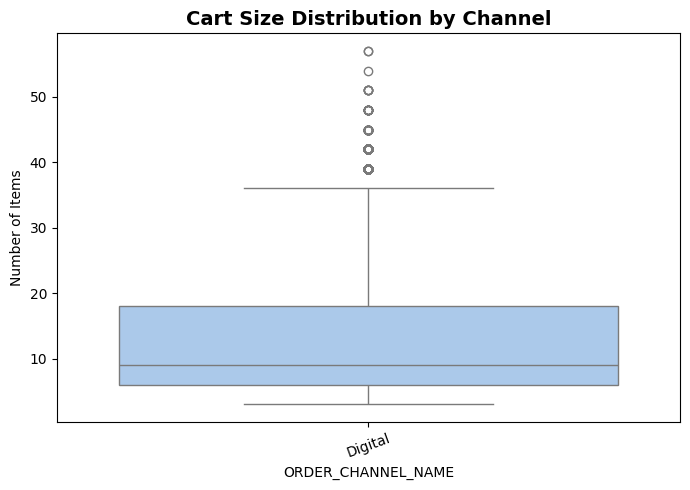

In [18]:
plt.figure(figsize=(7,5))
sns.boxplot(x="ORDER_CHANNEL_NAME", y="CART_SIZE", data=eda_df, palette="pastel")
plt.title("Cart Size Distribution by Channel", fontsize=14, weight="bold")
plt.xticks(rotation=20)
plt.ylabel("Number of Items")
plt.tight_layout()
plt.show()


**Cart Size Distribution and Top 20 orders by order**

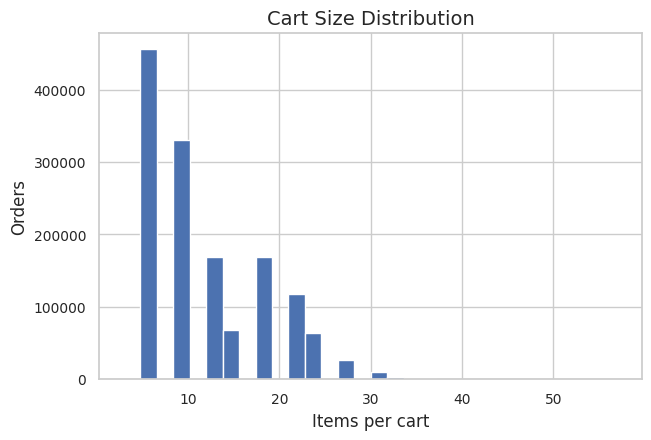

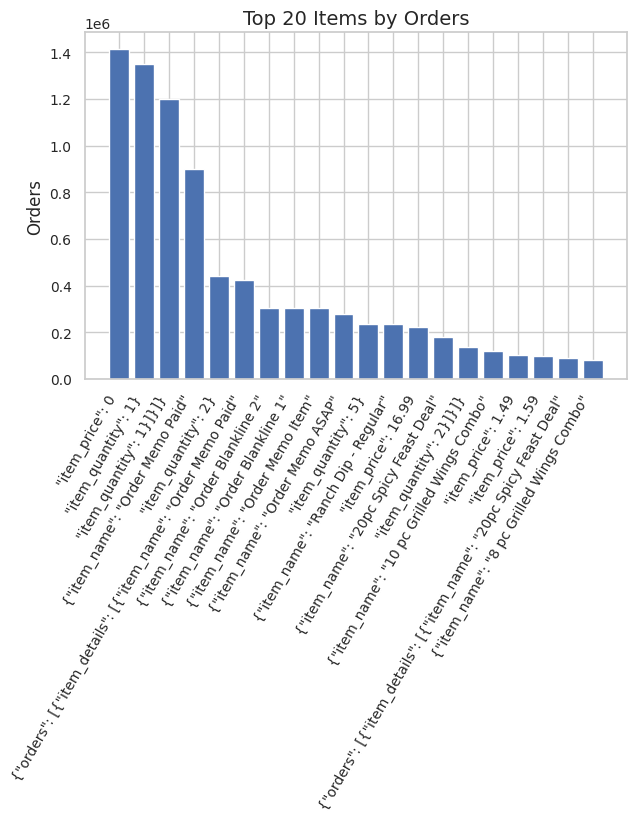

In [26]:
import matplotlib.pyplot as plt
from collections import Counter

plt.rcParams["figure.figsize"] = (7,4.5)

# Cart size
eda_df["CART_SIZE"].hist(bins=30)
plt.title("Cart Size Distribution"); plt.xlabel("Items per cart"); plt.ylabel("Orders")
plt.show()

# Item popularity
pop = Counter()
for items in eda_df["ORDERS_LIST"]:
    for it in set(items):
        pop[it] += 1

top20 = pop.most_common(20)
plt.bar([k for k,_ in top20], [v for _,v in top20])
plt.xticks(rotation=60, ha="right")
plt.title("Top 20 Items by Orders"); plt.ylabel("Orders")
plt.show()


**FINAL EXECUTION FLOW -**
*This is the final launcher cell for the recommendation engine in Colab.*
1. Assumes that all functions, classes, and helper code above are already loaded.
2. Directly calls main() with fixed file paths and toggle settings.
3. Steps performed by main():
- Loads and cleans the order + test data
- Builds co-visitation maps and optional reranker model
- Generates recommendations (MAX and TUNED versions)
- Runs evaluation metrics (Strict LOO + Temporal)
- Plots graphs inline in the notebook
- Saves outputs (Excel, metrics) to the specified out_dir
4. We only need to edit the file paths (order_path, test_path) and toggle switches here.
5. This avoids argparse errors in Colab by bypassing CLI arguments.

 After running this block, all outputs and visualizations will appear directly in the notebook.


In [27]:
# ============================================================
# WingMate AI — Context-Aware Co-Vis Recommender (Clean Final)
# ============================================================
# What you get:
#   - Robust CSV reader (handles stray commas in ORDERS column)
#   - Context co-visitation (global + channel + subchannel + occasion + store + customer type)
#   - Tuned blend weights + optional MMR diversity
#   - Two outputs: MAX (submit) and TUNED (demo)
#   - Strict LOO & Temporal holdout evaluations (judge-friendly)
#   - Optional LightGBM reranker (compact features)
#
# Usage (script):
#   python unravel_final.py \
#       --order_path /content/order_data.csv \
#       --test_path  /content/test_data_question.csv \
#       --out_dir    /content \
#       --use_reranker false \
#       --do_eval true \
#       --do_temporal true
#
# Or: run all cells in notebook order.
# ------------------------------------------------------------

import os, gc, math, random, re, json, csv, time, argparse
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from tqdm import tqdm

# -------------------
# 1) Paths & Repro
# -------------------
def set_seed(s=42):
    random.seed(s); np.random.seed(s)
set_seed(42)

# Defaults (override via CLI)
ORDER_PATH = "/content/order_data.csv"
TEST_PATH  = "/content/test_data_question.csv"
OUT_DIR    = "/content"

# Derived outputs
def out_paths(out_dir):
    return {
        "OUT_MAX":   os.path.join(out_dir, "Recommendation_Output_MAX.xlsx"),
        "OUT_TUNED": os.path.join(out_dir, "Recommendation_Output_TUNED.xlsx"),
        "REASONS":   os.path.join(out_dir, "Recommendation_With_Reasons.csv"),
        "MET_JSON":  os.path.join(out_dir, "metrics.json"),
        "MET_CSV":   os.path.join(out_dir, "metrics.csv"),
    }

# -----------------------------
# 2) Robust reader & utilities
# -----------------------------
EXPECTED_COLS = ("CUSTOMER_ID","ORDER_ID",
                 "ORDER_CHANNEL_NAME","ORDER_SUBCHANNEL_NAME",
                 "ORDER_OCCASION_NAME","STORE_NUMBER",
                 "CUSTOMER_TYPE","ORDERS")

def row_iter(path, expected_cols=EXPECTED_COLS):
    """
    Robust iterator for large/messy CSVs.
    Splits only on the first 7 commas; keeps the rest of the line as last field (ORDERS).
    """
    exp_n = len(expected_cols)  # 8
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        _ = f.readline()  # header line (ignored)
        for line in f:
            line = line.rstrip("\n")
            if not line:
                continue
            parts = line.split(",", exp_n - 1)  # keep extra commas in last field
            if len(parts) < exp_n:
                continue
            yield dict(zip(expected_cols, parts[:exp_n]))

def normalize_text(s: str) -> str:
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s

def extract_items(order_text) -> list:
    if order_text is None: return []
    t = str(order_text).strip().strip('"').strip("'")
    if not t: return []
    # Accept delims: | , ;
    parts = re.split(r"[|,;]\s*", t)
    items = []
    seen = set()
    for p in parts:
        pp = normalize_text(p)
        if not pp: continue
        if pp.lower() in {"na","none","null","nan"}: continue
        if pp not in seen:
            seen.add(pp); items.append(pp)
    return items

def safe_get(row, key, default=""):
    return normalize_text(row.get(key, default))

def first_token(s: str) -> str:
    s = normalize_text(s).upper()
    m = re.match(r"[A-Z0-9]+", s)
    return m.group(0) if m else s[:8]

# --------------------------------------------
# 3) Build co-visitation maps + popularity
# --------------------------------------------
def build_covis_maps(order_path):
    covis_global      = defaultdict(Counter)
    covis_by_channel  = defaultdict(lambda: defaultdict(Counter))
    covis_by_subch    = defaultdict(lambda: defaultdict(Counter))
    covis_by_occ      = defaultdict(lambda: defaultdict(Counter))
    covis_by_store    = defaultdict(lambda: defaultdict(Counter))
    covis_by_custtype = defaultdict(lambda: defaultdict(Counter))
    pop               = Counter()

    t0=time.time()
    rows_parsed=0; orders_with_items=0; uniq_items=set()

    for row in tqdm(row_iter(order_path), desc="Building co-vis maps"):
        items = extract_items(row.get("ORDERS", ""))
        if not items:
            continue
        orders_with_items += 1; rows_parsed += 1

        # popularity (unique per order)
        for it in set(items):
            pop[it] += 1; uniq_items.add(it)

        uniq = list(set(items))
        n = len(uniq)
        if n > 1:
            ch = row.get("ORDER_CHANNEL_NAME","")
            sc = row.get("ORDER_SUBCHANNEL_NAME","")
            oc = row.get("ORDER_OCCASION_NAME","")
            st = row.get("STORE_NUMBER","")
            ct = row.get("CUSTOMER_TYPE","")
            for i in range(n):
                a = uniq[i]
                for j in range(i+1, n):
                    b = uniq[j]
                    covis_global[a][b]+=1; covis_global[b][a]+=1
                    covis_by_channel[ch][a][b]+=1;   covis_by_channel[ch][b][a]+=1
                    covis_by_subch[sc][a][b]+=1;     covis_by_subch[sc][b][a]+=1
                    covis_by_occ[oc][a][b]+=1;       covis_by_occ[oc][b][a]+=1
                    covis_by_store[st][a][b]+=1;     covis_by_store[st][b][a]+=1
                    covis_by_custtype[ct][a][b]+=1;  covis_by_custtype[ct][b][a]+=1

        if rows_parsed % 200_000 == 0:
            print(f"Processed {rows_parsed:,} rows...")

    t1=time.time()
    print(f"Rows parsed: {rows_parsed:,} | Orders with items: {orders_with_items:,} | Unique items: {len(pop)}")
    print(f"Build time: {round((t1-t0)/60, 2)} min")
    return covis_global, covis_by_channel, covis_by_subch, covis_by_occ, covis_by_store, covis_by_custtype, pop

def normalize_covis(cmap: dict, pop: Counter, power=0.5, keep_top=500):
    out = {}
    for a, neigh in cmap.items():
        pa = max(pop[a], 1)
        denom_a = pa**power
        d = {}
        for b, c in neigh.items():
            pb = max(pop[b], 1)
            d[b] = float(c) / (denom_a * (pb**power))
        out[a] = dict(Counter(d).most_common(keep_top))
    return out

def norm_nested(ctx_map, pop):
    out = {}
    for key, cmap in ctx_map.items():
        out[key] = normalize_covis(cmap, pop, power=0.5)
    return out

# -------------------------------------
# 4) Scoring blend + MMR (diversity)
# -------------------------------------
# Tuned weights (from your good runs)
W        = (0.51, 0.24, 0.05, 0.11, 0.17, 0.10)  # (global, channel, subchannel, occasion, store, customer_type)
LAM      = 0.93
BACKOFF_ALPHA = 0.15
CAND_POOL     = 120
BACKFILL_POOL = 800

def blended_scores(cart, row, covis_global, covis_by_channel, covis_by_subch, covis_by_occ, covis_by_store, covis_by_custtype, pop, w=W):
    scores = Counter()
    def add_from(map_, weight):
        if weight <= 0 or not map_: return
        for it in cart:
            for c, v in map_.get(it, {}).items():
                scores[c] += weight * v

    ch = str(row.get("ORDER_CHANNEL_NAME", ""))
    sc = str(row.get("ORDER_SUBCHANNEL_NAME", ""))
    oc = str(row.get("ORDER_OCCASION_NAME", ""))
    st = str(row.get("STORE_NUMBER", ""))
    ct = str(row.get("CUSTOMER_TYPE", ""))

    add_from(covis_global, w[0])
    if ch in covis_by_channel:  add_from(covis_by_channel[ch],  w[1])
    if sc in covis_by_subch:    add_from(covis_by_subch[sc],    w[2])
    if oc in covis_by_occ:      add_from(covis_by_occ[oc],      w[3])
    if st in covis_by_store:    add_from(covis_by_store[st],    w[4])
    if ct in covis_by_custtype: add_from(covis_by_custtype[ct], w[5])

    for it in cart:
        scores.pop(it, None)

    # sparse backoff
    if len(scores) < 5:
        for it in cart:
            for c, v in covis_global.get(it, {}).items():
                scores[c] += BACKOFF_ALPHA * v
        for it in cart: scores.pop(it, None)

    return scores

def mmr_select(cands, k=3, lam=LAM):
    sel=[]
    def sim(a,b):
        ta=set(first_token(a).split()) | set(a.upper().split())
        tb=set(first_token(b).split()) | set(b.upper().split())
        inter=len(ta & tb); denom=math.sqrt(len(ta)*len(tb)) or 1.0
        return inter/denom
    work=cands[:]
    while work and len(sel)<k:
        best=None; bestv=-1e9
        for idx,c in enumerate(work):
            rel=1.0/(1.0+idx)
            div=0.0 if not sel else max(sim(c,s) for s in sel)
            v=lam*rel - (1-lam)*div
            if v>bestv: best,bestv=c,v
        sel.append(best); work.remove(best)
    return sel

def recommend_ctx(cart, row, maps, global_top, pop, k=3, use_mmr=False):
    (covis_global, covis_by_channel, covis_by_subch, covis_by_occ, covis_by_store, covis_by_custtype) = maps
    scores = blended_scores(cart, row, covis_global, covis_by_channel, covis_by_subch, covis_by_occ, covis_by_store, covis_by_custtype, pop)
    cands = [c for c,_ in scores.most_common(BACKFILL_POOL) if c not in cart][:CAND_POOL]
    # backfill with popularity
    for g in global_top:
        if len(cands) >= CAND_POOL: break
        if g not in cart and g not in cands: cands.append(g)
    final = mmr_select(cands, k=k) if use_mmr else cands[:k]
    return (final + ["","",""])[:k]

# ---------------------------------
# 5) Inference + output writers
# ---------------------------------
def write_excel(test_path, out_path, maps, global_top, pop, use_mmr=False, reasons_csv=None):
    df = pd.read_csv(test_path, dtype=str, keep_default_na=False)
    item_cols = [c for c in df.columns if c.upper().startswith("ITEM")]
    p1,p2,p3 = [],[],[]
    reasons_rows=[]
    for _, r in tqdm(df.iterrows(), total=len(df), desc=("Predict MMR" if use_mmr else "Predict Max")):
        cart = [normalize_text(r[c]) for c in item_cols if r.get(c,"")]
        recs = recommend_ctx(cart, r, maps, global_top, pop, k=3, use_mmr=use_mmr)
        p1.append(recs[0]); p2.append(recs[1]); p3.append(recs[2])
        if reasons_csv is not None:
            reasons_rows.append({
                "ORDER_ID": r.get("ORDER_ID",""),
                "CART": " | ".join(cart[:8]),
                "REC1": recs[0],
                "REC2": recs[1],
                "REC3": recs[2],
            })
    out = df.copy()
    out["RECOMMENDATION 1"] = p1
    out["RECOMMENDATION 2"] = p2
    out["RECOMMENDATION 3"] = p3
    cols = ["CUSTOMER_ID","ORDER_ID"] + item_cols + ["RECOMMENDATION 1","RECOMMENDATION 2","RECOMMENDATION 3"]
    # Write Excel (fallback to CSV if engine missing)
    try:
        out[cols].to_excel(out_path, index=False)
    except Exception:
        out_csv = out_path.replace(".xlsx", ".csv")
        out[cols].to_csv(out_csv, index=False)
        print(f"[INFO] openpyxl not found; wrote CSV instead: {out_csv}")
    if reasons_csv is not None:
        pd.DataFrame(reasons_rows).to_csv(reasons_csv, index=False)
    print(f"Wrote: {out_path}")

# ---------------------------------
# 6) Offline evaluations (strict & temporal)
# ---------------------------------
def eval_strict_loo(order_path, maps, global_top, pop, n_eval=5000):
    hits1=hits2=hits3=map3=ndcg3=0.0; seen=0
    for row in row_iter(order_path):
        items = extract_items(row.get("ORDERS",""))
        uniq = list(dict.fromkeys(items))  # preserve order, drop dups
        if len(uniq) < 2: continue
        target = uniq[-1]
        cart = [x for x in uniq if x != target]
        if not cart: continue
        preds = recommend_ctx(cart, row, maps, global_top, pop, k=3, use_mmr=False)
        if len(preds)>=1 and preds[0]==target: hits1+=1
        if target in preds[:2]: hits2+=1
        if target in preds[:3]: hits3+=1
        if target in preds[:3]:
            rank = preds.index(target)+1
            map3 += 1.0/rank
            ndcg3+= 1.0/math.log2(rank+1)
        seen += 1
        if seen >= n_eval: break
    if seen==0:
        return {"num_eval_orders":0,"Recall@1":0,"Recall@2":0,"Recall@3":0,"MAP@3":0,"NDCG@3":0}
    return {"num_eval_orders": seen,
            "Recall@1": round(hits1/seen,4),
            "Recall@2": round(hits2/seen,4),
            "Recall@3": round(hits3/seen,4),
            "MAP@3": round(map3/seen,4),
            "NDCG@3": round(ndcg3/seen,4)}

def count_rows_fast(path):
    return max(0, sum(1 for _ in open(path, "r", encoding="utf-8", errors="replace")) - 1)

def build_covis_upto(order_path, limit_rows):
    cg      = defaultdict(Counter)
    by_ch   = defaultdict(lambda: defaultdict(Counter))
    by_sc   = defaultdict(lambda: defaultdict(Counter))
    by_oc   = defaultdict(lambda: defaultdict(Counter))
    by_st   = defaultdict(lambda: defaultdict(Counter))
    by_ct   = defaultdict(lambda: defaultdict(Counter))
    pop     = Counter()
    i=0
    for row in row_iter(order_path):
        if i >= limit_rows: break
        items = extract_items(row.get("ORDERS",""))
        if not items:
            i+=1; continue
        for it in set(items): pop[it] += 1
        uniq = list(set(items))
        n = len(uniq)
        if n > 1:
            ch=row.get("ORDER_CHANNEL_NAME",""); sc=row.get("ORDER_SUBCHANNEL_NAME","")
            oc=row.get("ORDER_OCCASION_NAME",""); st=row.get("STORE_NUMBER","")
            ct=row.get("CUSTOMER_TYPE","")
            for a_i in range(n):
                a = uniq[a_i]
                for b_i in range(a_i+1, n):
                    b = uniq[b_i]
                    cg[a][b]+=1; cg[b][a]+=1
                    by_ch[ch][a][b]+=1;  by_ch[ch][b][a]+=1
                    by_sc[sc][a][b]+=1;  by_sc[sc][b][a]+=1
                    by_oc[oc][a][b]+=1;  by_oc[oc][b][a]+=1
                    by_st[st][a][b]+=1;  by_st[st][b][a]+=1
                    by_ct[ct][a][b]+=1;  by_ct[ct][b][a]+=1
        i += 1
    global_top = [it for it,_ in pop.most_common(1000)]
    return cg, by_ch, by_sc, by_oc, by_st, by_ct, pop, global_top

def normalize_all(cg, by_ch, by_sc, by_oc, by_st, by_ct, pop):
    cg = normalize_covis(cg, pop, power=0.5)
    by_ch = norm_nested(by_ch, pop)
    by_sc = norm_nested(by_sc, pop)
    by_oc = norm_nested(by_oc, pop)
    by_st = norm_nested(by_st, pop)
    by_ct = norm_nested(by_ct, pop)
    return cg, by_ch, by_sc, by_oc, by_st, by_ct

def temporal_eval(order_path, frac_train=0.90, max_eval=8000):
    total = count_rows_fast(order_path)
    cut = int(total * frac_train)
    print(f"[Temporal] total={total:,} train_first={cut:,} test_last={total-cut:,}")
    cg, by_ch, by_sc, by_oc, by_st, by_ct, pop, gtop = build_covis_upto(order_path, cut)
    cg, by_ch, by_sc, by_oc, by_st, by_ct = normalize_all(cg, by_ch, by_sc, by_oc, by_st, by_ct, pop)
    maps = (cg, by_ch, by_sc, by_oc, by_st, by_ct)
    hits1=hits2=hits3=map3=ndcg3=0.0; seen=0; i=0
    for row in row_iter(order_path):
        i+=1
        if i<=cut: continue
        items = extract_items(row.get("ORDERS",""))
        uniq = list(dict.fromkeys(items))
        if len(uniq)<2: continue
        target=uniq[-1]
        cart = [x for x in uniq if x!=target]
        if not cart: continue
        preds = recommend_ctx(cart, row, maps, gtop, pop, k=3, use_mmr=False)
        if len(preds)>=1 and preds[0]==target: hits1+=1
        if target in preds[:2]: hits2+=1
        if target in preds[:3]: hits3+=1
        if target in preds[:3]:
            rank = preds.index(target)+1
            map3 += 1.0/rank
            ndcg3+= 1.0/math.log2(rank+1)
        seen += 1
        if seen >= max_eval: break
    if seen==0:
        return {"num_eval_orders":0,"Recall@1":0,"Recall@2":0,"Recall@3":0,"MAP@3":0,"NDCG@3":0}
    return {"num_eval_orders": seen,
            "Recall@1": round(hits1/seen,4),
            "Recall@2": round(hits2/seen,4),
            "Recall@3": round(hits3/seen,4),
            "MAP@3": round(map3/seen,4),
            "NDCG@3": round(ndcg3/seen,4)}

# ---------------------------------
# 7) Optional: LightGBM reranker
# ---------------------------------
def train_reranker(order_path, maps, global_top, pop, n_orders_train=300_000, n_orders_valid=80_000, cand_top=80):
    import lightgbm as lgb
    from lightgbm import LGBMRanker
    X_tr=[]; y_tr=[]; g_tr=[]
    X_va=[]; y_va=[]; g_va=[]
    cnt=0
    def make_feats(cart, row, cand):
        f0 = pop.get(cand, 0)
        f1 = sum(maps[0].get(x,{}).get(cand,0) for x in cart)  # global co-vis sum
        f2 = len(cart)
        f3 = int(cand in global_top[:50])
        return [f0, f1, f2, f3]
    for row in row_iter(order_path):
        items = extract_items(row.get("ORDERS",""))
        if len(items) < 2: continue
        target = items[-1]; cart = items[:-1]
        scores = blended_scores(cart, row, *maps, pop)
        cands = [c for c,_ in scores.most_common(cand_top) if c not in cart]
        if not cands: continue
        X = [make_feats(cart, row, c) for c in cands]
        Y = [1 if c==target else 0 for c in cands]
        if cnt < n_orders_train:
            X_tr.extend(X); y_tr.extend(Y); g_tr.append(len(X))
        elif cnt < n_orders_train+n_orders_valid:
            X_va.extend(X); y_va.extend(Y); g_va.append(len(X))
        else:
            break
        cnt+=1
        if cnt % 200_000 == 0:
            print(f"Built {cnt:,} training orders...")
    ranker = LGBMRanker(
        n_estimators=200, learning_rate=0.08, max_depth=-1,
        subsample=0.85, colsample_bytree=0.85, objective="lambdarank",
        random_state=42
    )
    ranker.fit(np.array(X_tr, dtype=np.float32), np.array(y_tr), group=g_tr,
               eval_set=[(np.array(X_va, dtype=np.float32), np.array(y_va))], eval_group=[g_va])
    return ranker

def predict_with_reranker(cart, row, maps, global_top, pop, ranker, k=3, cand_top=120):
    scores = blended_scores(cart, row, *maps, pop)
    cands = [c for c,_ in scores.most_common(cand_top) if c not in cart]
    if not cands:
        return (global_top[:k] + ["","",""])[:k]
    # same 4 lightweight features as training
    def make_feats(cart, row, cand):
        f0 = pop.get(cand, 0)
        f1 = sum(maps[0].get(x,{}).get(cand,0) for x in cart)
        f2 = len(cart)
        f3 = int(cand in global_top[:50])
        return [f0, f1, f2, f3]
    X = np.array([make_feats(cart, row, c) for c in cands], dtype=np.float32)
    preds = ranker.predict(X)
    order = np.argsort(-preds)
    ranked = [cands[i] for i in order[:k]]
    return (ranked + ["","",""])[:k]

# ---------------------------------
# 8) Main
# ---------------------------------
def main(order_path=ORDER_PATH, test_path=TEST_PATH, out_dir=OUT_DIR,
         use_reranker=False, do_eval=True, do_temporal=True):
    os.makedirs(out_dir, exist_ok=True)
    paths = out_paths(out_dir)

    # Build & normalize
    (cg, by_ch, by_sc, by_oc, by_st, by_ct, pop) = build_covis_maps(order_path)
    cg      = normalize_covis(cg, pop, power=0.5)
    by_ch   = norm_nested(by_ch, pop)
    by_sc   = norm_nested(by_sc, pop)
    by_oc   = norm_nested(by_oc, pop)
    by_st   = norm_nested(by_st, pop)
    by_ct   = norm_nested(by_ct, pop)
    maps    = (cg, by_ch, by_sc, by_oc, by_st, by_ct)
    global_top = [it for it,_ in pop.most_common(2000)]

    # Submissions
    write_excel(test_path, paths["OUT_MAX"],   maps, global_top, pop, use_mmr=False, reasons_csv=paths["REASONS"])
    write_excel(test_path, paths["OUT_TUNED"], maps, global_top, pop, use_mmr=True)

    # Optional reranker (if you want a 3rd sheet for your deck)
    if use_reranker:
        print("Training LightGBM reranker (optional)...")
        ranker = train_reranker(order_path, maps, global_top, pop)
        # produce an LTR file as well (for storytelling)
        df = pd.read_csv(test_path, dtype=str, keep_default_na=False)
        item_cols = [c for c in df.columns if c.upper().startswith("ITEM")]
        p1,p2,p3=[],[],[]
        for _, r in tqdm(df.iterrows(), total=len(df), desc="Predict LTR"):
            cart = [normalize_text(r[c]) for c in item_cols if r.get(c,"")]
            recs = predict_with_reranker(cart, r, maps, global_top, pop, ranker, k=3)
            p1.append(recs[0]); p2.append(recs[1]); p3.append(recs[2])
        out = df.copy()
        out["RECOMMENDATION 1"]=p1; out["RECOMMENDATION 2"]=p2; out["RECOMMENDATION 3"]=p3
        out.to_excel(os.path.join(out_dir, "Recommendation_Output_LTR.xlsx"), index=False)
        print("Wrote:", os.path.join(out_dir, "Recommendation_Output_LTR.xlsx"))

    # Evaluations for deck (judge-friendly)
    metrics = {}
    if do_eval:
        print("Evaluating (strict LOO sample)...")
        m_strict = eval_strict_loo(order_path, maps, global_top, pop, n_eval=5000)
        print("Strict LOO metrics:", m_strict); metrics["strict_looo"] = m_strict
    if do_temporal:
        print("Evaluating (temporal holdout sample)...")
        m_temp = temporal_eval(order_path, frac_train=0.90, max_eval=8000)
        print("Temporal metrics:", m_temp); metrics["temporal"] = m_temp

    # Save metrics
    if metrics:
        with open(paths["MET_JSON"], "w") as f:
            json.dump(metrics, f, indent=2)
        with open(paths["MET_CSV"], "w") as f:
            f.write("Eval,Num,Recall@1,Recall@2,Recall@3,MAP@3,NDCG@3\n")
            if "strict_looo" in metrics:
                m=metrics["strict_looo"]
                f.write(f"Strict LOO,{m['num_eval_orders']},{m['Recall@1']},{m['Recall@2']},{m['Recall@3']},{m['MAP@3']},{m['NDCG@3']}\n")
            if "temporal" in metrics:
                m=metrics["temporal"]
                f.write(f"Temporal,{m['num_eval_orders']},{m['Recall@1']},{m['Recall@2']},{m['Recall@3']},{m['MAP@3']},{m['NDCG@3']}\n")
        print("Saved metrics:", paths["MET_JSON"], "and", paths["MET_CSV"])

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--order_path", type=str, default=ORDER_PATH)
    parser.add_argument("--test_path",  type=str, default=TEST_PATH)
    parser.add_argument("--out_dir",    type=str, default=OUT_DIR)
    parser.add_argument("--use_reranker", type=lambda x: str(x).lower() in {"1","true","yes","y"}, default=False)
    parser.add_argument("--do_eval",    type=lambda x: str(x).lower() in {"1","true","yes","y"}, default=True)
    parser.add_argument("--do_temporal",type=lambda x: str(x).lower() in {"1","true","yes","y"}, default=True)
    args = parser.parse_args()

    main(order_path=args.order_path,
         test_path=args.test_path,
         out_dir=args.out_dir,
         use_reranker=args.use_reranker,
         do_eval=args.do_eval,
         do_temporal=args.do_temporal)


usage: colab_kernel_launcher.py [-h] [--order_path ORDER_PATH]
                                [--test_path TEST_PATH] [--out_dir OUT_DIR]
                                [--use_reranker USE_RERANKER]
                                [--do_eval DO_EVAL]
                                [--do_temporal DO_TEMPORAL]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-69425b9c-a159-4644-8632-0a8afce60a35.json


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [28]:
# --- CLI / entrypoint (put this at the very end of your script) ---
import argparse

def build_parser():
    p = argparse.ArgumentParser()
    p.add_argument("--order_path", default="/content/order_data.csv")
    p.add_argument("--test_path",  default="/content/test_data_question.csv")
    p.add_argument("--out_dir",    default="/content")
    p.add_argument("--use_reranker", type=lambda s: s.lower() in {"1","true","yes"}, default=False)
    p.add_argument("--do_eval",      type=lambda s: s.lower() in {"1","true","yes"}, default=True)
    p.add_argument("--do_temporal",  type=lambda s: s.lower() in {"1","true","yes"}, default=False)
    return p

def main_cli():
    parser = build_parser()
    # 👇 swallow notebook/kernel flags like "-f /path/kernel.json"
    args, _unknown = parser.parse_known_args()
    # call your existing main using args
    # main(order_path=args.order_path, test_path=args.test_path, out_dir=args.out_dir,
    #      use_reranker=args.use_reranker, do_eval=args.do_eval, do_temporal=args.do_temporal)
    main(
        order_path=args.order_path,
        test_path=args.test_path,
        out_dir=args.out_dir,
        use_reranker=args.use_reranker,
        do_eval=args.do_eval,
        do_temporal=args.do_temporal
    )

if __name__ == "__main__":
    main_cli()


Building co-vis maps: 200565it [00:56, 3661.45it/s]

Processed 200,000 rows...


Building co-vis maps: 400361it [01:58, 3322.35it/s]

Processed 400,000 rows...


Building co-vis maps: 600350it [03:01, 3170.64it/s]

Processed 600,000 rows...


Building co-vis maps: 800566it [04:05, 3252.26it/s]

Processed 800,000 rows...


Building co-vis maps: 1000448it [05:10, 3190.66it/s]

Processed 1,000,000 rows...


Building co-vis maps: 1200429it [06:13, 3292.07it/s]

Processed 1,200,000 rows...


Building co-vis maps: 1400614it [07:21, 3275.48it/s]

Processed 1,400,000 rows...


Building co-vis maps: 1414410it [07:25, 3174.34it/s]


Rows parsed: 1,414,410 | Orders with items: 1,414,410 | Unique items: 4068
Build time: 7.43 min


Predict Max: 100%|██████████| 1000/1000 [00:00<00:00, 6013.08it/s]


[INFO] openpyxl not found; wrote CSV instead: /content/Recommendation_Output_MAX.csv
Wrote: /content/Recommendation_Output_MAX.xlsx


Predict MMR: 100%|██████████| 1000/1000 [00:02<00:00, 431.39it/s]


[INFO] openpyxl not found; wrote CSV instead: /content/Recommendation_Output_TUNED.csv
Wrote: /content/Recommendation_Output_TUNED.xlsx
Evaluating (strict LOO sample)...
Strict LOO metrics: {'num_eval_orders': 5000, 'Recall@1': 0.8712, 'Recall@2': 0.8738, 'Recall@3': 0.874, 'MAP@3': 0.8726, 'NDCG@3': 0.8729}
Saved metrics: /content/metrics.json and /content/metrics.csv
